In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
#source: https://www.kaggle.com/datasets/hariharanpavan/bank-marketing-dataset-analysis-classification

data = pd.read_csv("bank-full.csv")

data.rename(columns = {"y" : "target"}, inplace = True)
data = data.drop('duration',axis=1) #removing "duration" as it impacts the output target (duration =0 -> Y = "No")
data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [5]:
data.shape

(45211, 16)

In [6]:
data.groupby('target').count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
target,,,,,,,,,,,,,,,
no,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922
yes,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289


## Missing values

In [7]:
def missing_values(df):
    total = df.shape[0]
    #missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    percentage = {}
    for col in df.columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        percentage[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))


missing_values(data)

age : 0 (0.0%)
job : 0 (0.0%)
marital : 0 (0.0%)
education : 0 (0.0%)
default : 0 (0.0%)
balance : 0 (0.0%)
housing : 0 (0.0%)
loan : 0 (0.0%)
contact : 0 (0.0%)
day : 0 (0.0%)
month : 0 (0.0%)
campaign : 0 (0.0%)
pdays : 0 (0.0%)
previous : 0 (0.0%)
poutcome : 0 (0.0%)
target : 0 (0.0%)


In [8]:
#creating a list of the numerical variables

data.info()

num_df= data.select_dtypes(include = int)
numerical_cols = list(num_df.columns)

numerical_cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  target     45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

## Outlier Analysis

In [9]:
#the function can be called without print details, to only return a "Gaussian" or "Not Gaussian" string, or can be called with extensive details with print_details = True
def check_gaussian_distribution(dataframe, attribute, alpha, print_details = False):
	#Each test looks at the question of whether a sample was drawn from a Gaussian distribution from a slightly different perspective.
	#The Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data
	#The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution
	#Anderson-Darling Test can be used to check whether a data sample is normal;it is a modified version of the more sophisticated nonparametric goodness-of-fit statistical test Kolmogorov-Smirnov
	#A feature of the Anderson-Darling test is that it returns a list of critical values rather than a single p-value. This can provide the basis for a more thorough interpretation of the result.
	from scipy.stats import shapiro
	from scipy.stats import normaltest
	from scipy.stats import anderson
	import warnings
	warnings.filterwarnings("ignore")
	data = dataframe[attribute].values
	shapirostat, p = shapiro(data)
	k2stat, l = normaltest(data)
	result = anderson(data)

	for i in range(len(result.critical_values)):
		sl, cv = result.significance_level[i], result.critical_values[i]
	if (print_details == True):
		print("🟢🟢🟢🟢🟢 Normality Tests 🟢🟢🟢🟢🟢")
		print("H0: variable follows a Gaussian distribution\nH1: variable does not follow a Gaussian distribution" )
		print("------------------------------------------")
		print('Shapiro Statistics=%.3f, p=%.3f' % (shapirostat, p))
		if p > alpha:
			print('Shapiro test: Sample looks Gaussian (fail to reject H0)')
		else:
			print('Shapiro test: Sample does not look Gaussian (reject H0)')
		print("------------------------------------------")
		print('K^2 Statistics=%.3f, p=%.3f' % (k2stat, l))
		if l > alpha:
			print('K^2 test: Sample looks Gaussian (fail to reject H0)')
		else:
			print('K^2 test: Sample does not look Gaussian (reject H0)')
		print("------------------------------------------")
		print('Anderson-Darling Statistic: %.3f' % result.statistic)

		if result.statistic < result.critical_values[i]:
			print('%.3f: %.3f, data looks normal from an Anderson-Darling perspective (fail to reject H0)' % (sl, cv))
		else:
			print('%.3f: %.3f, data does not look normal from an Anderson-Darling perspective (reject H0)' % (sl, cv))
		print("------------------------------------------")
		if ((p>alpha) & (l> alpha) & (result.statistic < result.critical_values[i]) ):
			print("All of the normality tests conclude that the attribute " + attribute + " is extracted from a Gaussian distribution")
		
		else:
			print("At least 1 of the normality tests indicate that the attribute " + attribute + " does not follow a Gaussian distribution")
		
	
	#Critical values in a statistical test are a range of pre-defined significance boundaries at which the H0 can be failed to be rejected if
	# the calculated statistic is less than the critical value. 
	# Rather than just a single p-value, the test returns a critical value for a range of different commonly used significance levels.
	if ((p>alpha) & (l> alpha) & (result.statistic < result.critical_values[i])):
		return "Gaussian"
	else:
		return "Not Gaussian"
	
#check_gaussian_distribution(data, 'age', 0.05, True)

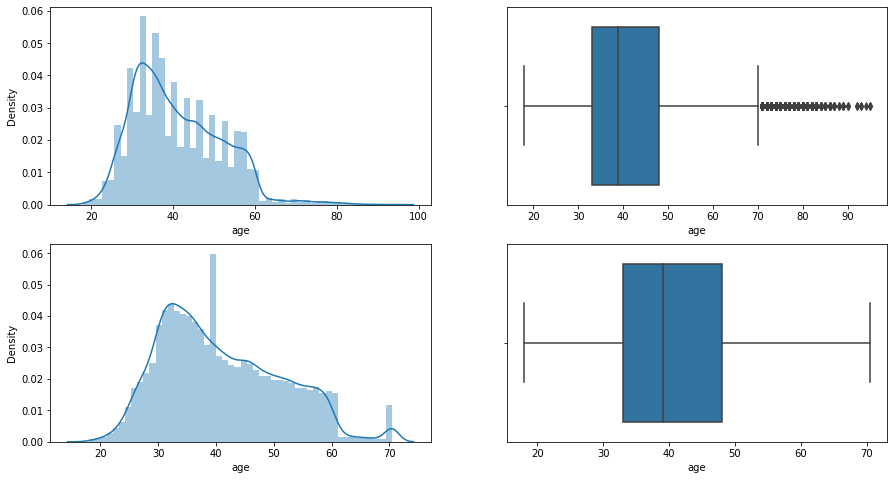

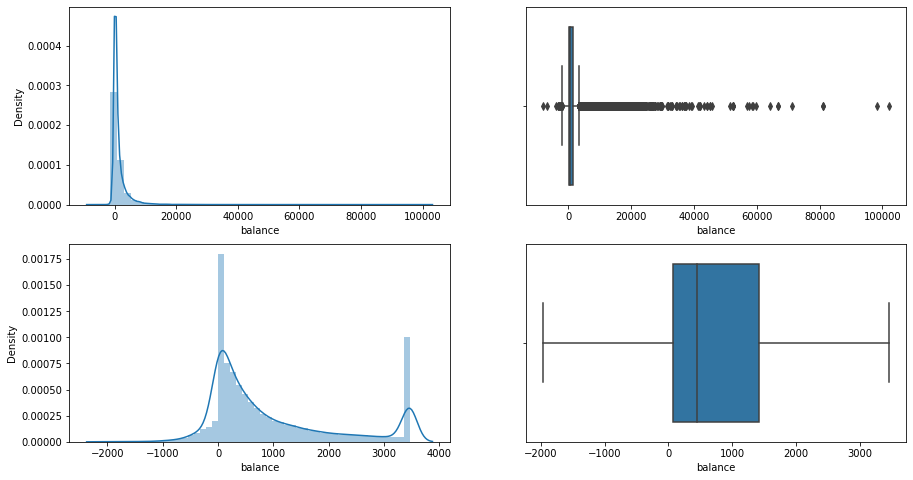

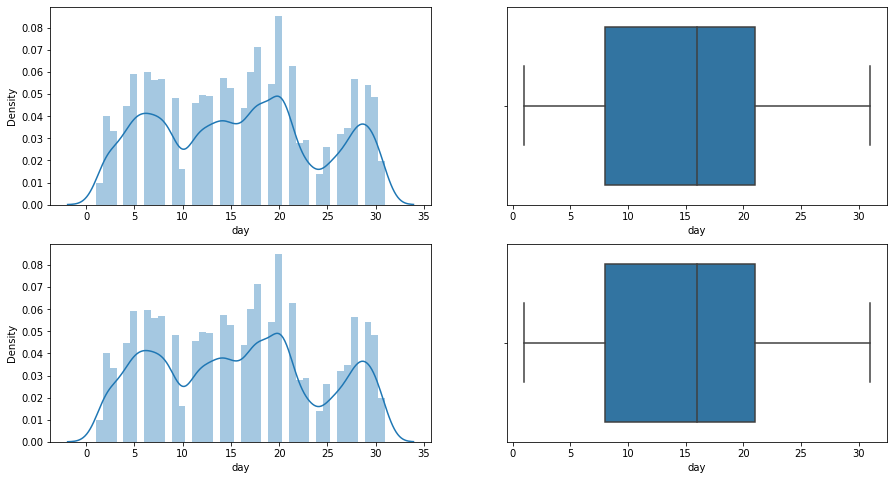

KeyError: 'duration'

In [10]:
#the following function will clean the data of outliers by using capping, if they exist, and plot the histogram and boxplot before and after
def cap_outliers(df, numerical):
    #normal distribution: The data points which fall below mean-3*(sigma) or above mean+3*(sigma) are outliers; 
    #skewed distribution: The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.
    import warnings
    warnings.filterwarnings("ignore")
    new_df_cap = data.copy()
    for col in numerical:
        varcheck = check_gaussian_distribution(df, col, 0.05)
        if varcheck == "Not Gaussian":   
            percentile25 = df[col].quantile(0.25)
            percentile75 = df[col].quantile(0.75)
            IQR = percentile75 - percentile25

            upper_limit = percentile75 + 1.5 * IQR
            lower_limit = percentile25 - 1.5 * IQR
            
            new_df_cap[col] = np.where(
                new_df_cap[col] > upper_limit,
                upper_limit,
                np.where(
                    new_df_cap[col] < lower_limit,
                    lower_limit,
                    new_df_cap[col]
                        )
                )
        else:  #if the variable follows a normal distribution
            upper_limit = new_df_cap[col].mean() + 3*df[col].std()
            lower_limit = new_df_cap[col].mean() - 3*df[col].std()
            new_df_cap[col] = np.where(
                new_df_cap[col]>upper_limit,
                upper_limit,
                np.where(
                    new_df_cap[col]<lower_limit,
                    lower_limit,
                    new_df_cap[col]
                        )
                )
        plt.figure(figsize=(15,8))
        plt.subplot(2,2,1)
        sns.distplot(df[col])
        plt.subplot(2,2,2)
        sns.boxplot(df[col])
        plt.subplot(2,2,3)
        sns.distplot(new_df_cap[col])
        plt.subplot(2,2,4)
        sns.boxplot(new_df_cap[col])
        plt.show()
    return new_df_cap


#we do not want to cap outliers in pdays and previous, because they carry important information
capped_df = cap_outliers(data, ['age', 'balance', 'day', 'duration', 'campaign'])



## Encoding categorical variables

In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_df= capped_df.select_dtypes(include= object)
cat_columns = cat_df.columns

for col in cat_columns:
    print('The feature {} has {} categories'.format(col,len(capped_df[col].unique())))


lbe = LabelEncoder()

data_transformed = capped_df.copy()
for col in cat_columns:
    data_transformed[col] = lbe.fit_transform(data_transformed[col])

data_transformed

The feature job has 12 categories
The feature marital has 3 categories
The feature education has 4 categories
The feature default has 2 categories
The feature housing has 2 categories
The feature loan has 2 categories
The feature contact has 3 categories
The feature month has 12 categories
The feature poutcome has 4 categories
The feature target has 2 categories


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58.0,4,1,2,0,2143.0,1,0,2,5.0,8,261.0,1.0,-1,0,3,0
1,44.0,9,2,1,0,29.0,1,0,2,5.0,8,151.0,1.0,-1,0,3,0
2,33.0,2,1,1,0,2.0,1,1,2,5.0,8,76.0,1.0,-1,0,3,0
3,47.0,1,1,3,0,1506.0,1,0,2,5.0,8,92.0,1.0,-1,0,3,0
4,33.0,11,2,3,0,1.0,0,0,2,5.0,8,198.0,1.0,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,9,1,2,0,825.0,0,0,0,17.0,9,643.0,3.0,-1,0,3,1
45207,70.5,5,0,0,0,1729.0,0,0,0,17.0,9,456.0,2.0,-1,0,3,1
45208,70.5,5,1,1,0,3462.0,0,0,0,17.0,9,643.0,5.0,184,3,2,1
45209,57.0,1,1,1,0,668.0,0,0,1,17.0,9,508.0,4.0,-1,0,3,0


## Discretizing numerical variables

In [ ]:

# This function takes in a dataframe and a set list of columns
# returns a copy of the dataframe with discretized cols
def find_optimal_binning_split(dataframe, cols):
    df = dataframe.copy()
    target = np.array(df['target'])
    for i in cols:
        array = np.array(df[i])
        optb = OptimalBinning(name=i, dtype="numerical", solver="cp", outlier_detector='range')
        print(optb)
        optb.fit(array, target)
        splits = optb.splits
        print(i)
        print('SPLITS:',splits)

        # Converting the splits array back into list before passing it as param 'bins' to pd.cut
        bins = splits.tolist()
        # Add value -inf at the start of the array, and inf at the end 
        bins.insert(0,-np.inf)
        bins.append(np.inf)

        print('BINS:',bins)
        print('--------------------------------------------------------------')
        # Replace the column with the result of cut
        df[i] = pd.cut(df[i],bins,include_lowest=True, labels=False )
    return df


final_df_transformed = find_optimal_binning_split(data_transformed, numerical_cols)

final_df_transformed

OptimalBinning(name='age', outlier_detector='range')
age
SPLITS: [29.5 31.5 35.5 37.5 39.5 43.5 45.5 51.5 58.5]
BINS: [-inf, 29.5, 31.5, 35.5, 37.5, 39.5, 43.5, 45.5, 51.5, 58.5, inf]
--------------------------------------------------------------
OptimalBinning(name='balance', outlier_detector='range')
balance
SPLITS: [ -46.5   60.5  126.5  194.5  458.5  798.5 1578.5 2324.5]
BINS: [-inf, -46.5, 60.5, 126.5, 194.5, 458.5, 798.5, 1578.5, 2324.5, inf]
--------------------------------------------------------------
OptimalBinning(name='day', outlier_detector='range')
day
SPLITS: [ 4.5 16.5 18.5 21.5]
BINS: [-inf, 4.5, 16.5, 18.5, 21.5, inf]
--------------------------------------------------------------
OptimalBinning(name='duration', outlier_detector='range')
duration
SPLITS: [ 60.5  77.5  92.5 114.5 129.5 145.5 163.5 184.5 205.5 249.5 292.5 364.5
 521.5]
BINS: [-inf, 60.5, 77.5, 92.5, 114.5, 129.5, 145.5, 163.5, 184.5, 205.5, 249.5, 292.5, 364.5, 521.5, inf]
-------------------------------

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,8,4,1,2,0,7,1,0,2,1,8,10,0,0,0,3,0
1,6,9,2,1,0,1,1,0,2,1,8,6,0,0,0,3,0
2,2,2,1,1,0,1,1,1,2,1,8,1,0,0,0,3,0
3,7,1,1,3,0,6,1,0,2,1,8,2,0,0,0,3,0
4,2,11,2,3,0,1,0,0,2,1,8,8,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,7,9,1,2,0,6,0,0,0,2,9,13,2,0,0,3,1
45207,9,5,0,0,0,7,0,0,0,2,9,12,1,0,0,3,1
45208,9,5,1,1,0,8,0,0,0,2,9,13,4,0,0,2,1
45209,8,1,1,1,0,5,0,0,1,2,9,12,3,0,0,3,0


In [ ]:
#removing "duration" as it impacts the output target (duration =0 -> target = "No") also the duration is not known before a call is performed

final_df_transformed=final_df_transformed.drop('duration',axis=1)

NameError: name 'final_df_transformed' is not defined

In [ ]:
final_df_transformed.to_csv('transformed_df.csv',index=False)